### Loading and processing the MNIST dataset
In this example, we will load the MNIST dataset from Hugging Face, 
use `torchdata.nodes` to process it and generate training batches.

In [1]:
from datasets import load_dataset
# Load the mnist dataset from HuggingFace datasets and convert the format to "torch"
dataset = load_dataset("ylecun/mnist").with_format("torch")

# Getting the train dataset
dataset = dataset["train"]

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import default_collate, RandomSampler, SequentialSampler

torch.manual_seed(42)

# Defining samplers
# Since datasets is a Map-style dataset, we can setup a sampler to shuffle the data
sampler = RandomSampler(dataset)

In [3]:
# Now we can set up some torchdata.nodes to create our pre-proc pipeline
from torchdata.nodes import MapStyleWrapper, ParallelMapper, Batcher, PinMemory, Loader

# All torchdata.nodes.BaseNode implementations are Iterators.
# MapStyleWrapper creates an Iterator that combines sampler and dataset to create an iterator.
#
# Under the hood, MapStyleWrapper just does:
# > node = IterableWrapper(sampler)
# > node = Mapper(node, map_fn=dataset.__getitem__)  # You can parallelize this with ParallelMapper

node = MapStyleWrapper(map_dataset=dataset, sampler=sampler)

# Now we want to transform the raw inputs. We can just use another Mapper with
# a custom map_fn to perform this. Using ParallelMapper allows us to use multiple
# threads (or processes) to parallelize this work and have it run in the background
# We need a mapper function to convert a dtype and also normalize
def map_fn(item):
    image = item["image"].to(torch.float32)/255
    label = item["label"]

    return {"image":image, "label":label}
    
node = ParallelMapper(node, map_fn=map_fn, num_workers=2) # output items are Dict[str, tensor]


# Hyperparameters
batch_size = 2 

# Next we batch the inputs, and then apply a collate_fn with another Mapper
# to stack the tensor. We use torch.utils.data.default_collate for this
node = Batcher(node, batch_size=batch_size) # output items are List[Dict[str, tensor]]
node = ParallelMapper(node, map_fn=default_collate, num_workers=2) # outputs are Dict[str, tensor]

# we can optionally apply pin_memory to the batches
if torch.cuda.is_available():
    node = PinMemory(node)

# Since nodes are iterators, they need to be manually .reset() between epochs.
# Instead, we can wrap the root node in Loader to convert it to a more conventional Iterable.
loader = Loader(node)

{'image': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]]), 'label': tensor([1, 4])}
There are 2 samples in this batch


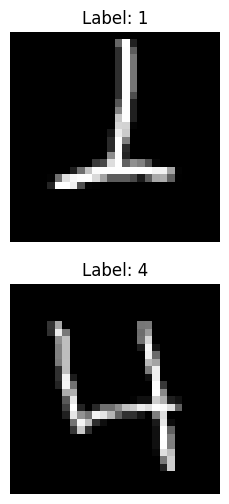

In [4]:
# Once we have the loader, we can get batches from it over multiple epochs, to train the model
# Let us look at one batch 
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, figsize=(8, 6))

batch = next(iter(loader))
             

print(batch)
print(f"There are {len(batch)} samples in this batch")

# Since we used default_collate, each batch is a dictionary, with two keys: "image" and "label"
# The value of key "image" is a stacked tensor of images in the batch
# Similarly, the value of key "label" is a stacked tensor of labels in the batch
images = batch["image"]
labels = batch["label"]

#let's also display the two items
for i in range(len(images)):
    axs[i].imshow(images[i].squeeze(), cmap='gray')
    axs[i].set_title(f"Label: {labels[i]}")   
    axs[i].set_axis_off()
